# 4. Construcción, Entrenamiento y Evaluación del Modelo para el reconocimiento de Posturas corporales de arbitraje en esgrima (señas arbitrales)

Una vez identificado el problema y los datos necesarios, empezamos a construir y entrenar un modelo de aprendizaje de máquina para intentar identificar las señas arbitrales en posturas corporales de un individuo. 

Para ello seguí los siguientes pasos:

* Instalar librerías y dependencias
* Importar librerías
* Diseño de funciones para la captura de los puntos corporales con MediaPipe
* Parametrizar las carpetas, número de secuencias y longitud de la secuencia
* Recolección de los datos para el entrenamiento
* Preprocesamiento de los datos, creación de variables y etiquetas
* Construcción, Entrenamiento y Evaluación del Modelo 1 - Primer grupo 
* Construcción, Entrenamiento y Evaluación del Modelo 2 - Segundo grupo
* Test en tiempo real

Se construirán 2 modelos de 8 señas cada uno para facilitar el proceso predictivo y el funcionamiento en la fase de lanzamiento, esto como solución a la problemática encontrada en la fase de exploración donde se identificaron algunas señas con similitudes en los patrones de movimiento, lo cual, con la cantidad limitada de datos podría dificultar la precisión del modelo y sus predicciones.

## Instalar Dependencias y Librerias

In [1]:
#!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib
#!pip list

## Importar librerias

In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

## Diseño de funciones para la captura de los puntos corporales con MediaPipe

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

#### Función para detectar los puntos corporales

In [4]:


def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # conversion del color BGR to RGB
    image.flags.writeable = False                  # image is no longer writeable 
    results = model.process(image)                 # make prediction
    image.flags.writeable = True                   # image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # reversion del color RGB to BGR
    return image, results

#### Función para dibujar los puntos corporales de manera estilizada

In [5]:
# funcion para dibujar los puntos corporales (estilizada)

def draw_styled_landmarks(image, results):
    #mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACE_CONNECTIONS) # draw face
    
    # draw pose
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(0,255,255), thickness=3, circle_radius=3)
                             )
    
    # draw left hand
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=4), #naranja
                             mp_drawing.DrawingSpec(color=(0,128,255), thickness=3, circle_radius=3) # amarillo
                             )
    
    # draw right hand
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(255,255,255), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(255,255,0), thickness=3, circle_radius=3)
                             ) 

#### Función para extraer los valores de cada punto corporal (Extract Keypoint values)

In [6]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(1404*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #return np.concatenate([facer,pose,lh,rh])
    return np.concatenate([pose,lh,rh])

## Parametrizar las carpetas, número de secuencias y longitud de la secuencia

Estipulamos la carpeta donde se guardarán las coordenadas X, Y y Z de cada punto corporal. Así mismo, se estableció un total de 50 secuencias (videos) para cada seña arbitral, con una longitud de 30 frames por secuencia.

In [7]:
# path for exported data
DATA_PATH = os.path.join('MP_data4')

# acciones que estamos tratando de detectar con el modelo
actions = np.array(['punta en linea','ataque','tocado','no valido','parada','tocado doble','nada', 'listos'])

# primer grupo = 'punta en linea','ataque','tocado','no valido','parada','tocado doble','nada', 'listos'
# segundo grupo = 'adelante','enguardia','punto izquierda','punto doble','no','incorrecto','alto','simultaneo'

#acciones = 
#'adelante'
#'alto'
#'enguardia'
#'listos'
#'punto izquierda'
#'punto doble'
#'punta en linea'
#'ataque'
#'tocado'
#'no valido'
#'parada'
#'tocado doble'
#'simultaneo'
#'nada'
#'no'
#'incorrecto'

# cantidad de secuencias de frames  (videos de la accion) que se extraen
no_sequences = 50 #100

# cantidad de frames de cada video que entran en la detección
sequence_length = 30

In [8]:
for action in actions:
    for sequence in range(no_sequences):
    #for sequence in range(85,100):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

## Recolección de los datos para el entrenamiento

Utilizando OpenCV,  MediaPipe y las funciones creadas previamente, se realizó la recolección de los datos y las coordenadas de los puntos corporales a través de la webcam del computador. 

In [43]:
cap = cv2.VideoCapture(0)
# set mediapipe model
with mp_holistic.Holistic(static_image_mode=True,model_complexity=1,smooth_landmarks=True,min_detection_confidence=0.3,
                          min_tracking_confidence=0.5) as holistic:
    
    # loop through actions
    for action in actions:
        # loop through sequences aka videos
        for sequence in range(no_sequences):
            #loop through video lenght aka frames/sequence lenght
            for frame_num in range(sequence_length):
    
                # reed feed
                ret, frame = cap.read()

                # make detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # apply wait logic
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Postura: {} numero {}'.format(action, sequence), (15,30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4, cv2.LINE_AA)
                    # show on screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else:
                    cv2.putText(image, 'Postura {} numero {}'.format(action, sequence), (15,30),
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 4, cv2.LINE_AA)
                    # show on screen
                    cv2.imshow('OpenCV Feed', image)

            
                # Export Keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)


                # break
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

## Preprocesamiento de los datos, creación de variables y etiquetas (Preprocess Data, Create Labels and Features)

In [9]:
from sklearn.model_selection import train_test_split


In [10]:
from tensorflow.keras.utils import to_categorical

NotFoundError: /usr/local/lib/python3.8/dist-packages/tensorflow/core/kernels/libtfkernel_sobol_op.so: undefined symbol: _ZN10tensorflow6StatusC1ENS_5error4CodeEN4absl14lts_2020_09_2311string_viewEOSt6vectorINS_10StackFrameESaIS7_EE

In [11]:
from tensorflow.keras.utils import to_categorical

Creamos un diccionario con las etiquetas para el primer modelo con 8 señas arbitrales. 

In [12]:
label_map = {label:num for num, label in enumerate(actions)}

In [13]:
label_map

{'punta en linea': 0,
 'ataque': 1,
 'tocado': 2,
 'no valido': 3,
 'parada': 4,
 'tocado doble': 5,
 'nada': 6,
 'listos': 7}

Luego unificamos los datos recolectados para cada seña en el paso previo generando un array con los datos de las diferentes secuencias de las señas y sus respectivas coordenadas, así como un array con las etiquetas para cada una de las secuencias ordenadamente.

In [14]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
        

Vemos que la forma del array de las secuencias esta compuesta por 400 secuencias de 30 frames cada una y en cada uno de los frames están los 258 datos de las coordenadas de los puntos corporales estimados a través de MediaPipe

In [15]:
np.array(sequences).shape

(400, 30, 258)

Por su parte el array de las etiquetas contiene unicamente las 400 etiquetas correspondientes a cada secuencia.

In [16]:
np.array(labels).shape

(400,)

Por último, transformamos las etiquetas en una variable categórica y realizamos la partición de los datos en Train y Test.

In [17]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

Una vez los datos ya se encuentran organizados de la manera correcta para la construcción del modelo, procedemos a la construcción y entrenamiento del Modelo y la Red Neuronal 

# Build and Train LSTM Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard


In [20]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Construcción, Entrenamiento y Evaluación del Modelo 1 - Primer grupo de señas

In [21]:
# model structure
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(actions.shape[0],activation='softmax'))


In [22]:
# model compilation
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'] )

In [23]:
history = model.fit(X_train, y_train, epochs=55, callbacks=[tb_callback],validation_split = 0.1)

Epoch 1/55
11/11 [==============================] - 3s 104ms/step - loss: 2.0841 - categorical_accuracy: 0.1656 - val_loss: 2.0197 - val_categorical_accuracy: 0.2632
Epoch 2/55
11/11 [==============================] - 0s 44ms/step - loss: 1.9649 - categorical_accuracy: 0.3023 - val_loss: 1.6795 - val_categorical_accuracy: 0.3158
Epoch 3/55
11/11 [==============================] - 0s 45ms/step - loss: 1.7073 - categorical_accuracy: 0.4855 - val_loss: 1.2788 - val_categorical_accuracy: 0.5000
Epoch 4/55
11/11 [==============================] - 0s 45ms/step - loss: 1.4782 - categorical_accuracy: 0.4639 - val_loss: 1.2833 - val_categorical_accuracy: 0.5526
Epoch 5/55
11/11 [==============================] - 1s 46ms/step - loss: 1.5027 - categorical_accuracy: 0.6406 - val_loss: 1.3279 - val_categorical_accuracy: 0.5000
Epoch 6/55
11/11 [==============================] - 0s 44ms/step - loss: 1.5380 - categorical_accuracy: 0.3836 - val_loss: 1.1432 - val_categorical_accuracy: 0.6053
Epoch 7/5

11/11 [==============================] - 0s 45ms/step - loss: 0.1212 - categorical_accuracy: 0.9668 - val_loss: 0.4491 - val_categorical_accuracy: 0.8684
Epoch 51/55
11/11 [==============================] - 0s 45ms/step - loss: 0.3469 - categorical_accuracy: 0.8750 - val_loss: 0.2717 - val_categorical_accuracy: 0.9474
Epoch 52/55
11/11 [==============================] - 0s 45ms/step - loss: 0.4061 - categorical_accuracy: 0.8340 - val_loss: 0.2861 - val_categorical_accuracy: 0.8421
Epoch 53/55
11/11 [==============================] - 0s 45ms/step - loss: 0.1757 - categorical_accuracy: 0.8732 - val_loss: 0.1244 - val_categorical_accuracy: 0.9737
Epoch 54/55
11/11 [==============================] - 0s 45ms/step - loss: 0.1375 - categorical_accuracy: 0.9874 - val_loss: 0.1915 - val_categorical_accuracy: 0.9737
Epoch 55/55
11/11 [==============================] - 0s 46ms/step - loss: 0.0466 - categorical_accuracy: 0.9959 - val_loss: 0.4340 - val_categorical_accuracy: 0.8158


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            82688     
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 237,416
Trainable params: 237,416
Non-trainable params: 0
__________________________________________________

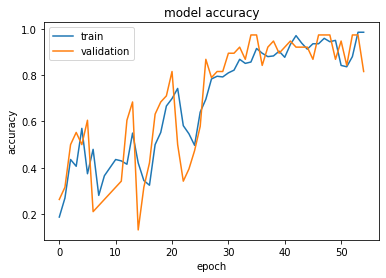

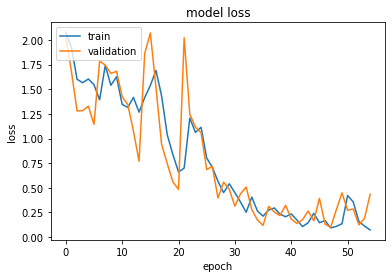

In [25]:
#  "Accuracy"
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Make Predictions

In [26]:
res = model.predict(X_test)

In [27]:
actions[np.argmax(res[1])]

'nada'

In [28]:
actions[np.argmax(y_test[1])]

'nada'

# Evaluating using a confusion matrix and accuracy

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [30]:
yhat = model.predict(X_test)

In [31]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [32]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[16,  0],
        [ 0,  4]],

       [[17,  0],
        [ 0,  3]],

       [[18,  0],
        [ 0,  2]],

       [[18,  0],
        [ 0,  2]],

       [[18,  0],
        [ 0,  2]],

       [[18,  0],
        [ 0,  2]],

       [[17,  0],
        [ 0,  3]],

       [[18,  0],
        [ 0,  2]]])

In [33]:
accuracy_score(ytrue, yhat)

1.0

# Construcción, Entrenamiento y Evaluación del Modelo 2 - Segundo grupo de señas

In [34]:
# path for exported data
DATA_PATH = os.path.join('MP_data4')

# acciones que estamos tratando de detectar con el modelo
actions2 = np.array(['adelante','enguardia','punto izquierda','punto doble','no','incorrecto','alto','simultaneo'])
# primer grupo = 'punta en linea','ataque','tocado','no valido','parada','tocado doble','nada', 'listos'
# segundo grupo = 'adelante','enguardia','punto izquierda','punto doble','no','incorrecto','alto','simultaneo'

#acciones = 
#'alto'
#'adelante'
#'enguardia'
#'listos'
#'punto izquierda'
#'punto doble'
#'punta en linea'
#'ataque'
#'tocado'
#'no valido'
#'parada'
#'tocado doble'
#'simultaneo'
#'nada'
#'no'
#'incorrecto'

# cantidad de secuencias de frames  (videos de la accion) que se extraen
no_sequences = 50 #100

# cantidad de frames de cada video que entran en la detección
sequence_length = 30

#------------------------------------------------------------------------------------------------


label_map2 = {label:num for num, label in enumerate(actions2)}

sequences2, labels2 = [], []
for action in actions2:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), '{}.npy'.format(frame_num)))
            window.append(res)
        sequences2.append(window)
        labels2.append(label_map2[action])

#----------------------------------------------------------------------------------------        

X2 = np.array(sequences2)
y2 = to_categorical(labels2).astype(int)


X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.05)

In [35]:
# model structure
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model2.add(LSTM(128, return_sequences=True, activation='relu'))
model2.add(LSTM(64, return_sequences=False, activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32,activation='relu'))
model2.add(Dense(actions.shape[0],activation='softmax'))


In [36]:
# model compilation
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'] )

In [37]:
history2 = model2.fit(X2_train, y2_train, epochs=55, callbacks=[tb_callback],validation_split = 0.1)

Epoch 1/55
11/11 [==============================] - 3s 125ms/step - loss: 2.0467 - categorical_accuracy: 0.1456 - val_loss: 2.2283 - val_categorical_accuracy: 0.0789
Epoch 2/55
11/11 [==============================] - 0s 45ms/step - loss: 1.7622 - categorical_accuracy: 0.2819 - val_loss: 1.5034 - val_categorical_accuracy: 0.4474
Epoch 3/55
11/11 [==============================] - 0s 45ms/step - loss: 1.3497 - categorical_accuracy: 0.5194 - val_loss: 1.4056 - val_categorical_accuracy: 0.5263
Epoch 4/55
11/11 [==============================] - 0s 44ms/step - loss: 1.3631 - categorical_accuracy: 0.5566 - val_loss: 1.3365 - val_categorical_accuracy: 0.3947
Epoch 5/55
11/11 [==============================] - 0s 46ms/step - loss: 1.2055 - categorical_accuracy: 0.4798 - val_loss: 1.3125 - val_categorical_accuracy: 0.3947
Epoch 6/55
11/11 [==============================] - 0s 45ms/step - loss: 1.0116 - categorical_accuracy: 0.5910 - val_loss: 0.8549 - val_categorical_accuracy: 0.6053
Epoch 7/5

11/11 [==============================] - 1s 47ms/step - loss: 0.0133 - categorical_accuracy: 0.9967 - val_loss: 0.0050 - val_categorical_accuracy: 1.0000
Epoch 51/55
11/11 [==============================] - 1s 47ms/step - loss: 0.0075 - categorical_accuracy: 0.9995 - val_loss: 0.0039 - val_categorical_accuracy: 1.0000
Epoch 52/55
11/11 [==============================] - 0s 46ms/step - loss: 0.0039 - categorical_accuracy: 0.9995 - val_loss: 0.0048 - val_categorical_accuracy: 1.0000
Epoch 53/55
11/11 [==============================] - 1s 46ms/step - loss: 0.0104 - categorical_accuracy: 0.9983 - val_loss: 0.0048 - val_categorical_accuracy: 1.0000
Epoch 54/55
11/11 [==============================] - 0s 46ms/step - loss: 0.0106 - categorical_accuracy: 0.9986 - val_loss: 0.0039 - val_categorical_accuracy: 1.0000
Epoch 55/55
11/11 [==============================] - 1s 48ms/step - loss: 0.0054 - categorical_accuracy: 0.9993 - val_loss: 0.0042 - val_categorical_accuracy: 1.0000


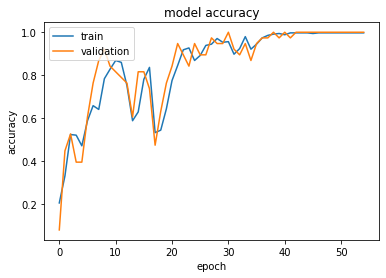

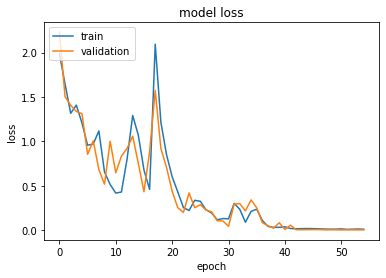

In [38]:
#  "Accuracy"
plt.plot(history2.history['categorical_accuracy'])
plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [39]:
yhat2 = model2.predict(X2_test)
ytrue2 = np.argmax(y2_test, axis=1).tolist()
yhat2 = np.argmax(yhat2, axis=1).tolist()

multilabel_confusion_matrix(ytrue2, yhat2)



array([[[19,  0],
        [ 0,  1]],

       [[18,  0],
        [ 0,  2]],

       [[18,  0],
        [ 0,  2]],

       [[16,  0],
        [ 0,  4]],

       [[16,  0],
        [ 0,  4]],

       [[19,  0],
        [ 0,  1]],

       [[16,  0],
        [ 0,  4]],

       [[18,  0],
        [ 0,  2]]])

In [40]:
accuracy_score(ytrue2, yhat2)

1.0

# Save Weights and Load Model

In [41]:
# save model
model.save('action_arb1.h5')
model2.save('action_arb2.h5')



In [41]:
#load model
# 1. run model structure
# 2. run model compilation

model.load_weights('action_arb1.h5')
model2.load_weights('action_arb2.h5')

# Test in Real Time

In [34]:
from scipy import stats

In [33]:
colors = [(117,245,16), (16,117,245), (16,117,245), (16,117,245), (16,117,245), (16,117,2), (16,117,2), (16,117,2)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [2]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.95

cap = cv2.VideoCapture(0)
# Set mediapipe model 
#with mp_holistic.Holistic(static_image_mode=True,model_complexity=1,smooth_landmarks=True,min_detection_confidence=0.3,
                          #min_tracking_confidence=0.5) as holistic:
with mp_holistic.Holistic(min_detection_confidence=0.7, min_tracking_confidence=0.7) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        #cv2.putText(image, ' '.join(sentence), (3,30), 
         #              cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, '{} - {:.2f}'.format(sentence[-1:],res[np.argmax(res)]),(3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

NameError: name 'cv2' is not defined

# Consideraciones Finales

Se construyeron 2 modelos de 8 señas arbitrales cada uno para facilitar el proceso de prediccion en la fase de lanzamiento. Los modelos lograron a su vez un accuracy de mas de 95% que era la meta pactada al inicio del proyecto.

Modelo 1:

* Acuraccy: 1.0

* señas: 'punta en linea','ataque','tocado','no valido','parada','tocado doble','nada', 'listos'

Modelo 2:

* Accuracy: 1.0

* Señas: 'adelante','enguardia','punto izquierda','punto doble','no','incorrecto','alto','simultaneo'

En este punto podemos realizar el lanzamiento de los modelos para ser utilizados por las personas para practicar las señas y posturas de arbitraje de esgrima.


# Fuentes 


Basado en https://www.youtube.com/watch?v=doDUihpj6ro&t=7833s

GitHub -> https://github.com/nicknochnack/ActionDetectionforSignLanguage
